## Pair neuropeptide ligand to GPCR receptor based on RipollSanchez...Scaeffer, 2023

/tmp/ipykernel_3273051/446178275.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Chart saved to ../plots/NPP_GPCR_pairing.png


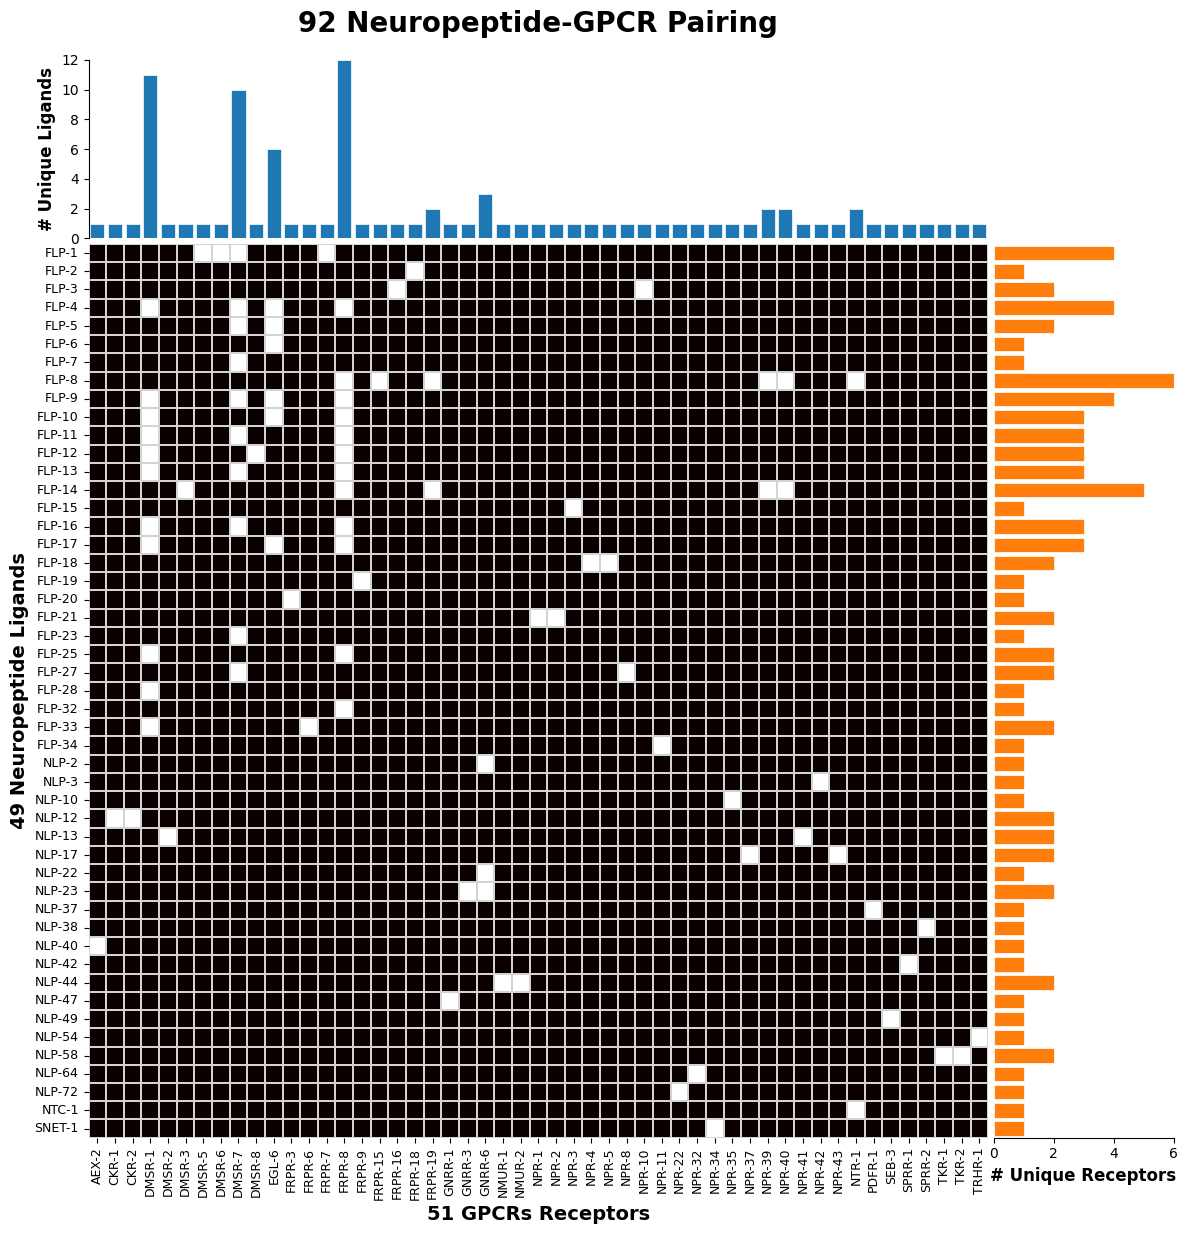

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from matplotlib.gridspec import GridSpec

# Custom sorting function: alphabetically then numerically
def natural_sort_key(s):
    parts = re.findall(r'[A-Za-z]+|\d+|[^A-Za-z0-9]+', s)
    result = []
    for part in parts:
        if part.isdigit():
            result.append((0, int(part)))
        else:
            result.append((1, str(part).upper()))
    return result

# Path to your data
csv_path = '../data/RipollSanchez2023/NPP_GPCR_info.csv'

# Load the data
df = pd.read_csv(csv_path)

# Create and sort pivot table
heatmap_data = pd.crosstab(df['GPCR receptor'], df['Neuropeptide ligand'])
sorted_gpcrs = sorted(heatmap_data.index.tolist(), key=natural_sort_key)
sorted_ligands = sorted(heatmap_data.columns.tolist(), key=natural_sort_key)
heatmap_data = heatmap_data.reindex(index=sorted_gpcrs, columns=sorted_ligands)

# Calculate marginal counts
receptor_counts = heatmap_data.sum(axis=1)
ligand_counts = heatmap_data.sum(axis=0)

# Create figure
fig = plt.figure(figsize=(14, 14))
gs = GridSpec(2, 2, figure=fig, 
              width_ratios=[5, 1], 
              height_ratios=[1, 5],
              hspace=0.01, wspace=0.01)

# Main heatmap
ax_heatmap = fig.add_subplot(gs[1, 0])
sns.heatmap(heatmap_data.T, 
            cmap='hot',
            cbar=False,
            linewidths=0.01,
            linecolor='lightgray',
            xticklabels=sorted_gpcrs, # Explicitly pass labels
            yticklabels=sorted_ligands,
            ax=ax_heatmap)

# --- RE-ADDING TICK LABELS AND FORMATTING ---
ax_heatmap.set_xticklabels(sorted_gpcrs, rotation=90, fontsize=9)
ax_heatmap.set_yticklabels(sorted_ligands, rotation=0, fontsize=9)
ax_heatmap.set_ylabel(f'{len(sorted_ligands)} Neuropeptide Ligands', fontsize=14, fontweight='bold')
ax_heatmap.set_xlabel(f'{len(sorted_gpcrs)} GPCRs Receptors', fontsize=14, fontweight='bold')

# Top bar chart
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_heatmap)
bar_positions_x = np.arange(len(receptor_counts)) + 0.5
ax_top.bar(bar_positions_x, receptor_counts.values, 
           width=0.8, color='tab:blue', edgecolor='white', linewidth=0.5)
ax_top.set_ylabel('# Unique Ligands', fontsize=12, fontweight='bold')
ax_top.tick_params(axis='x', labelbottom=False, bottom=False)
ax_top.set_ylim(0, max(receptor_counts.values))
ax_top.spines['top'].set_visible(False)
ax_top.spines['right'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.set_title(f'{sum(sum(heatmap_data.values))} Neuropeptide-GPCR Pairing', fontsize=20, fontweight='bold', pad=20)

# Right bar chart
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_heatmap)
bar_positions_y = np.arange(len(ligand_counts)) + 0.5
ax_right.barh(bar_positions_y, ligand_counts.values,
              height=0.8, color='tab:orange', edgecolor='white', linewidth=0.5)
ax_right.set_xlabel('# Unique Receptors', fontsize=12, fontweight='bold')
ax_right.set_xlim(0, max(ligand_counts.values))
ax_right.tick_params(axis='y', labelleft=False, left=False)
ax_right.spines['top'].set_visible(False)
ax_right.spines['right'].set_visible(False)
ax_right.spines['left'].set_visible(False)

# Clean up empty corner
ax_empty = fig.add_subplot(gs[0, 1])
ax_empty.axis('off')

plt.tight_layout()
output_path = '../plots/NPP_GPCR_pairing.png'
plt.savefig(output_path, dpi=600, bbox_inches='tight')
print(f"Chart saved to {output_path}")
plt.show()

## Pair neuropeptide ligand to GPCR receptor based on RipollSanchez...Scaeffer, 2023


Processing ../data/RipollSanchez2023/NPPpairsbyneuron_shortrange.csv
Data shape: (302, 92)

Processing ../data/RipollSanchez2023/NPPpairsbyneuron_midrange.csv
Data shape: (302, 92)

Processing ../data/RipollSanchez2023/NPPpairsbyneuron_longrange.csv
Data shape: (302, 92)

Combined statistics:
Total interactions: 6569
Non-zero entries: 92
Matrix sparsity: 96.3%


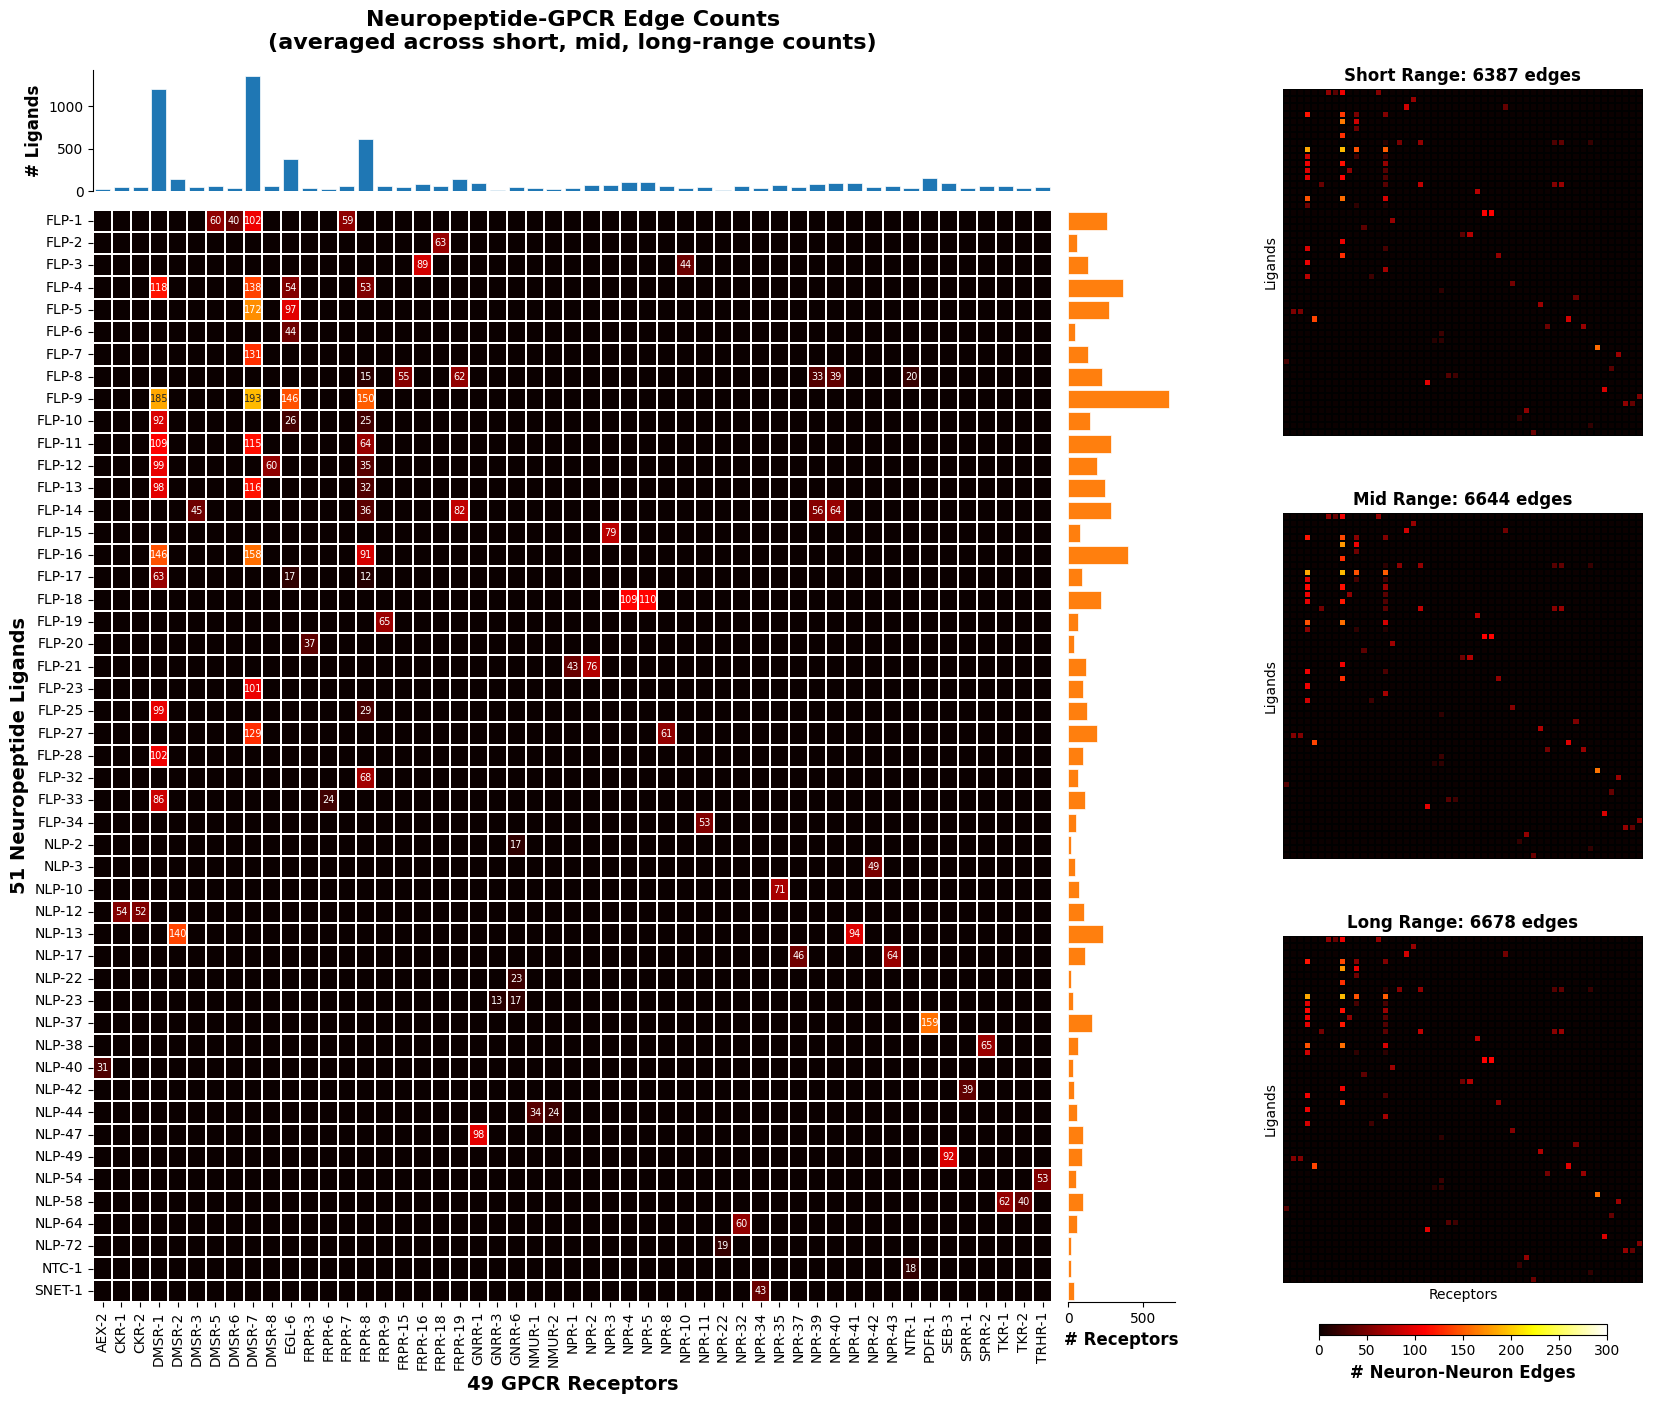

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # Required for anchoring

# Custom sorting function: alphabetically then numerically
def natural_sort_key(s):
    """
    Split string into alphabetic and numeric parts for natural sorting.
    E.g., 'FLP-1', 'FLP-2', 'FLP-10' will sort correctly as FLP-1, FLP-2, ..., FLP-9, FLP-10.
    This handles patterns like 'FLP-10' or 'NPR-3' by separating letters and numbers.
    """
    # Split on non-alphanumeric characters and digits
    parts = re.findall(r'[A-Za-z]+|\d+|[^A-Za-z0-9]+', s)
    result = []
    for part in parts:
        if part.isdigit():
            # Convert numeric parts to integers for proper numerical sorting
            result.append((0, int(part)))  # (0, number) sorts before (1, string)
        else:
            # Keep alphabetic/other parts as strings
            result.append((1, part.upper()))  # (1, string) for case-insensitive alpha sort
    return result

# Function to process a CSV file and return counts
def process_csv(filepath):
    df = pd.read_csv(filepath, index_col='rownames')
    print(f"\nProcessing {filepath}")
    print(f"Data shape: {df.shape}")
    
    neuropeptide_receptor_counts = defaultdict(int)
    
    for neuron in df.index:
        for col in df.columns:
            value = df.loc[neuron, col]
            if pd.notna(value):
                parts = value.split()
                if len(parts) == 2:
                    neuropeptide, receptor = parts
                    neuropeptide_receptor_counts[(neuropeptide, receptor)] += 1
    
    return neuropeptide_receptor_counts

# Process all three CSV files
shortrange_counts = process_csv('../data/RipollSanchez2023/NPPpairsbyneuron_shortrange.csv')
midrange_counts = process_csv('../data/RipollSanchez2023/NPPpairsbyneuron_midrange.csv')
longrange_counts = process_csv('../data/RipollSanchez2023/NPPpairsbyneuron_longrange.csv')

# Combine all counts for the combined plot
combined_counts = defaultdict(int)
for counts in [shortrange_counts, midrange_counts, longrange_counts]:
    for pair, count in counts.items():
        combined_counts[pair] += count

# Extract unique neuropeptides and receptors from combined data
all_neuropeptides = sorted(set([pair[0] for pair in combined_counts.keys()]))
all_receptors = sorted(set([pair[1] for pair in combined_counts.keys()]))

# Sort neuropeptides and receptors naturally
all_neuropeptides = sorted(all_neuropeptides, key=natural_sort_key)
all_receptors = sorted(all_receptors, key=natural_sort_key)

# Function to create adjacency matrix
def create_adjacency_matrix(counts, neuropeptides, receptors):
    matrix = np.zeros((len(neuropeptides), len(receptors)))
    for i, neuropeptide in enumerate(neuropeptides):
        for j, receptor in enumerate(receptors):
            if (neuropeptide, receptor) in counts:
                matrix[i, j] = counts[(neuropeptide, receptor)]
    return matrix

# Create matrices for all four plots
combined_matrix = create_adjacency_matrix(combined_counts, all_neuropeptides, all_receptors) / 3  # average across three ranges
shortrange_matrix = create_adjacency_matrix(shortrange_counts, all_neuropeptides, all_receptors)
midrange_matrix = create_adjacency_matrix(midrange_counts, all_neuropeptides, all_receptors)
longrange_matrix = create_adjacency_matrix(longrange_counts, all_neuropeptides, all_receptors)

# Print statistics for combined data
print(f"\nCombined statistics:")
print(f"Total interactions: {int(combined_matrix.sum())}")
print(f"Non-zero entries: {np.count_nonzero(combined_matrix)}")
print(f"Matrix sparsity: {(1 - np.count_nonzero(combined_matrix) / combined_matrix.size) * 100:.1f}%")

# Create custom annotation arrays (only show non-zero values)
def create_annot_array(matrix):
    annot = np.empty_like(matrix, dtype=object)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] > 0:
                annot[i, j] = f'{int(matrix[i, j])}'
            else:
                annot[i, j] = ''
    return annot

combined_annot = create_annot_array(combined_matrix)
shortrange_annot = create_annot_array(shortrange_matrix)
midrange_annot = create_annot_array(midrange_matrix)
longrange_annot = create_annot_array(longrange_matrix)

# --- FIGURE LAYOUT ---
fig = plt.figure(figsize=(20, 16))
outer_gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.15)

# Nested grid for the LEFT side
left_gs = outer_gs[0].subgridspec(2, 2, width_ratios=[9, 1], height_ratios=[1, 9],
                                  hspace=0.03, wspace=0.03)

# Nested grid for the RIGHT side
right_gs = outer_gs[1].subgridspec(3, 1, hspace=0.1)

# --- 1. COMBINED HEATMAP & MARGINALS (Left Side) ---
ax1 = fig.add_subplot(left_gs[1, 0])
ax_top = fig.add_subplot(left_gs[0, 0], sharex=ax1)
ax_right = fig.add_subplot(left_gs[1, 1], sharey=ax1)

sns.heatmap(combined_matrix, 
            xticklabels=all_receptors, yticklabels=all_neuropeptides,
            cmap='hot', cbar=False, linewidths=0.01, linecolor='white',
            ax=ax1, vmin=0, vmax=300, annot=combined_annot, fmt='',
            annot_kws={'size': 7})

# Increased label padding to make room for the colorbar below
ax1.set_xlabel(f'{len(all_neuropeptides)} GPCR Receptors', fontsize=14, fontweight='bold')
ax1.set_ylabel(f'{len(all_receptors)} Neuropeptide Ligands', fontsize=14, fontweight='bold')

# --- MARGINAL BARS (Top & Right) ---
receptor_sums = combined_matrix.sum(axis=0)
ligand_sums = combined_matrix.sum(axis=1)

bar_pos_x = np.arange(len(receptor_sums)) + 0.5
ax_top.bar(bar_pos_x, receptor_sums, width=0.8, color='tab:blue', edgecolor='white', linewidth=0.5)
ax_top.set_title('Neuropeptide-GPCR Edge Counts\n(averaged across short, mid, long-range counts)', fontsize=16, fontweight='bold', pad=15)
ax_top.set_ylabel('# Ligands', fontsize=12, fontweight='bold')
ax_top.tick_params(axis='x', labelbottom=False, bottom=False)
ax_top.spines[['top', 'right', 'bottom']].set_visible(False)

bar_pos_y = np.arange(len(ligand_sums)) + 0.5
ax_right.barh(bar_pos_y, ligand_sums, height=0.8, color='tab:orange', edgecolor='white', linewidth=0.5)
ax_right.set_xlabel('# Receptors', fontsize=12, fontweight='bold')
ax_right.tick_params(axis='y', labelleft=False, left=False)
ax_right.spines[['top', 'right', 'left']].set_visible(False)

# --- 2. STACKED HEATMAPS (Right Side) ---
axes_right = [fig.add_subplot(right_gs[i, 0]) for i in range(3)]
matrices = [shortrange_matrix, midrange_matrix, longrange_matrix]
titles = ['Short Range', 'Mid Range', 'Long Range']

for ax, mat, title in zip(axes_right, matrices, titles):
    sns.heatmap(mat, xticklabels=False, yticklabels=False,
                cmap='hot', cbar=False, linewidths=0.01, linecolor='black',
                square=True, ax=ax, vmin=0, vmax=300)
    ax.set_title(f"{title}: {int(mat.sum())} edges", fontsize=12, fontweight='bold')
    ax.set_ylabel('Ligands', fontsize=10)
axes_right[2].set_xlabel('Receptors', fontsize=10)

# --- UPDATED COLORBAR (Bottom Right of Last Subplot) ---
# Place colorbar at bottom right of the Long Range subplot (axes_right[2])
cb_ax = inset_axes(axes_right[2],
                   width="80%",   
                   height="3%",   
                   loc='lower center',
                   bbox_to_anchor=(0.0, -0.15, 1, 1), 
                   bbox_transform=axes_right[2].transAxes,
                   borderpad=0)

sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=300))
cb = fig.colorbar(sm, cax=cb_ax, orientation='horizontal')
cb.set_label('# Neuron-Neuron Edges', fontsize=12, fontweight='bold')
cb.ax.tick_params(labelsize=10)

plt.savefig('../plots/NPP_GPCR_edge_counts.png', dpi=600, bbox_inches='tight')
plt.show()